In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import re
import os
#ciaooo

%matplotlib inline
import matplotlib.pyplot as plt
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

From specifications and descriptions of the dataset we can infer the proper `dtype` for most of the columns:
- numerical : `int`,`float`
- text : `str`
- A low/finite number of values : `categorical`,`boolean`

In [11]:
class Dataset:
    def __init__(self, file:str):
        self.file_name : str = file
        self.types : dict = self.load_types()
        self.df : pd.DataFrame = None
        
    def name(self):
        return re.search(r'\/([\w\d]*)\.csv',self.file_name).group(1)
    
    def types_file(self):
        return '/kaggle/working/'+ self.name() +'.npy'
        
    def save_types(self):
        np.save(self.types_file(), self.types)
        
    def load_types(self):
        if os.path.isfile(self.types_file()):
            self.types = np.load(self.types_file(),allow_pickle='TRUE').item()
            return self.types
        return None
    
    def __getitem__(self,item):
        return self.df[item]


datasets = [
    Dataset(file='../input/instagram-dataset/instagram_profiles.csv'), 
    Dataset(file='../input/instagram-dataset/instagram_locations.csv'), 
    Dataset(file='../input/instagram-dataset/instagram_posts.csv')
]
profiles, locations, posts = datasets

profiles.types = {
#     'sid' : int,
    'profile_id' : int,
    'profile_name' : pd.StringDtype(storage='pyarrow'),
    'firstname_lastname' : pd.StringDtype(storage='pyarrow'),
    'description' : pd.StringDtype(storage='pyarrow'),
    'following' : int,
    'followers' : int,
    'n_posts' : int,
    'url' : pd.StringDtype(storage='pyarrow'),
#     'cts' : pd.DatetimeTZDtype(tz='UTC'), #obtained through parse_dates=['cts']
    'is_business_account' : pd.BooleanDtype()
}
posts.types = {
#     'sid' : int, # gives an error, maybe because it's the index?
    'sid_profile' : int,
    'post_id' : pd.StringDtype(storage='pyarrow'),
    'profile_id' : int,
    'location_id' : int,
    'description' : pd.StringDtype(storage='pyarrow'),
    'post_type' : pd.CategoricalDtype(categories=[1,2,3]),
    'numbr_likes' : int,
    'number_comments' : int
}
locations.types = {
#     'sid' : int, # gives an error, maybe because it's the index?
    'id' : int,
    'name' : pd.StringDtype(storage='pyarrow'),
    'street' : pd.StringDtype(storage='pyarrow'),
    'zip' : pd.StringDtype(storage='pyarrow'),
    'city' : pd.StringDtype(storage='pyarrow'),
    'region' : pd.StringDtype(storage='pyarrow'),
    'cd' : pd.CategoricalDtype(),
    'phone' : pd.StringDtype(storage='pyarrow'),
    'aj_exact_city_match' : pd.BooleanDtype(),
    'aj_exact_country_match' : pd.BooleanDtype(),
    'blurb' : pd.StringDtype(storage='pyarrow'),
    'dir_city_id' : pd.StringDtype(storage='pyarrow'),
    'dir_city_name' : pd.StringDtype(storage='pyarrow'),
    'dir_city_slug' : pd.StringDtype(storage='pyarrow'),
    'dir_country_id' : pd.CategoricalDtype(),
    'dir_country_name' : pd.CategoricalDtype(),
    'lat' : pd.Float32Dtype(),
    'lng' : pd.Float32Dtype(),
    'primary_alias_on_fb' : pd.StringDtype(storage='pyarrow'),
    'slug' : pd.StringDtype(storage='pyarrow'),
    'website' : pd.StringDtype(storage='pyarrow'),
}

In [12]:
def get_types(signed=True, unsigned=True, custom=[]):
    '''Returns a pandas dataframe containing the boundaries of each integer dtype'''
    # based on https://stackoverflow.com/a/57894540/9419492
    pd_types = custom
    if signed:
        pd_types += [pd.Int8Dtype() ,pd.Int16Dtype() ,pd.Int32Dtype(), pd.Int64Dtype()]
    if unsigned:
        pd_types += [pd.UInt8Dtype() ,pd.UInt16Dtype(), pd.UInt32Dtype(), pd.UInt64Dtype()]
    type_df = pd.DataFrame(data=pd_types, columns=['pd_type'])
    type_df['np_type'] = type_df['pd_type'].apply(lambda t: t.numpy_dtype)
    type_df['min_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).min)
    type_df['max_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).max)
    type_df['allow_negatives'] = type_df['min_value'] < 0
    type_df['size'] = type_df['np_type'].apply(lambda row: row.itemsize)
    type_df.sort_values(by=['size', 'allow_negatives'], inplace=True)
    return type_df.reset_index(drop=True)
    
get_types()

,pd_type,np_type,min_value,max_value,allow_negatives,size
0,UInt8,uint8,0,255,False,1
1,Int8,int8,-128,127,True,1
2,UInt16,uint16,0,65535,False,2
3,Int16,int16,-32768,32767,True,2
4,UInt32,uint32,0,4294967295,False,4
5,Int32,int32,-2147483648,2147483647,True,4
6,UInt64,uint64,0,18446744073709551615,False,8
7,Int64,int64,-9223372036854775808,9223372036854775807,True,8


In [17]:
def downcast_int(file_path, column:str, chunksize=10000, delimiter=',', signed=True, unsigned=True):
    '''Assigns the smallest possible dtype to an integer column of a csv'''
    types = get_types(signed, unsigned)
    negatives = False
    for chunk in pd.read_csv(file_path, usecols=[column],delimiter=delimiter,skiprows=lambda x:x%100==0,chunksize=chunksize):
        M = chunk[column].max()
        m = chunk[column].min()
        if not signed and not negatives and m < 0 :
            types = types[types['allow_negatives']] # removes unsigned rows
            negatives = True
        if m < types['min_value'].iloc[0]:
            types = types[types['min_value'] < m]
        if M > types['max_value'].iloc[0]:
            types = types[types['max_value'] > M]
        if len(types) == 1:
            print('early stop')
            break
    return types['pd_type'].iloc[0]

def optimize_cols(file, int_cols, delimiter=',', signed=True, unsigned=True):
    out = dict()
    for col in int_cols:
        out[col] = downcast_int(file, col, delimiter=delimiter, signed=signed, unsigned=unsigned)
    return out

In [18]:
for ds in datasets:
    if not ds.load_types():
        int_cols = [k for k,v in ds.types.items() if v is int]
        print(int_cols)
        ds.types.update(optimize_cols(ds.file_name, int_cols, delimiter='\t'))
        print(f'Optimized {len(int_cols)} types for {ds.name()}')
#     ds.types.update({k:pd.StringDtype(storage='pyarrow') for k,v in ds.types.items() if v==pd.StringDtype(storage='pyarrow')})
    ds.save_types()
#     print(ds.types)

In [15]:
SAMPLE_SIZE = 10000
for ds in datasets:
    ds.df = pd.read_csv(ds.file_name, dtype=ds.types, index_col='sid', delimiter='\t', parse_dates=['cts'], nrows=SAMPLE_SIZE)
    avg_mem_unoptimized = pd.read_csv(ds.file_name, index_col='sid', delimiter='\t', nrows=SAMPLE_SIZE).memory_usage(deep=True).sum()/SAMPLE_SIZE
    avg_mem_optimized = ds.df.memory_usage(deep=True).sum()/SAMPLE_SIZE
    print(f'{ds.name().ljust(19)} mean optimized memory usage per entry:  {round(avg_mem_optimized):3} B vs {round(avg_mem_unoptimized):4} B  : {round(avg_mem_optimized/avg_mem_unoptimized*100,2):5}%') 

ValueError: Missing column provided to 'parse_dates': 'cts'

In [ ]:
# Load test:  fails even with optimizing can't load everything in 16GB
# for ds in datasets:
#     ds.df = pd.read_csv(ds.file_name, dtype=ds.types, index_col='sid', delimiter='\t', parse_dates=['cts'])
#     print(f'Loaded {ds.name().ljust(19)}, size = {round(ds.df.memory_usage(deep=True).sum()/ 1024**3,2)}GB')
#     del ds.df

# Exploratory Data Analysis [RQ1]

### Profiles 
| Field | Description |
|---|---|
| SID | Sequence ID |
| profile_id | Instagrams ID |
| profile_name | profile name |
| firstname_lastname | firstname lastname |
| description | May contain '\n' |
| following | Number of following profile at the moment it was visited |
| followers | Number of followers at the moment it was visited |
| n_posts | Number of posts at the moment it was visited |
| url | Url in profile description |
| cts | Timestamp when the profile was visited |
| is_business_account | Boolean flag if that profile was makred by the owner as business account |

In [33]:
profiles.df.head()

,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
sid,,,,,,,,,,
4184446,4721049632,jphillip033,John Pierce,"""Document Everything Always""",250,146,170,<NA>,2019-08-01 14:38:55.394000-04:00,False
4184457,590583002,mama_haas,Deanna,Trying to enjoy the simple things in life. Kni...,534,1145,2878,www.etsy.com/shop/MamaHaas69,2019-08-01 14:39:36.526000-04:00,False
4184460,1074146658,yellowlightbreen,Eliza Gray,Maine is for Lovers,469,324,431,elizajanegray.com,2019-08-01 14:39:54.407000-04:00,False
4184461,1472038842,tec1025,Thomas Clark,<NA>,<NA>,<NA>,<NA>,<NA>,2019-08-01 14:40:06.472000-04:00,<NA>
4184462,3531420803,luckyfluff,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2019-08-01 14:40:07.806000-04:00,<NA>


In [54]:
profiles.df[['following', 'followers', 'n_posts']].describe()

,following,followers,n_posts
count,6379.000000,6.379000e+03,6379.000000
mean,805.535037,6.636363e+03,579.079636
std,1057.607105,6.963743e+04,1049.373491
min,0.000000,0.000000e+00,0.000000
25%,226.000000,2.730000e+02,89.000000
50%,498.000000,6.710000e+02,251.000000
75%,948.500000,1.490000e+03,662.000000
max,7505.000000,2.793338e+06,37753.000000


In [55]:
profiles.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 4184446 to 4195503
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype                                 
---  ------               --------------  -----                                 
 0   profile_id           10000 non-null  UInt64                                
 1   profile_name         10000 non-null  string                                
 2   firstname_lastname   9571 non-null   string                                
 3   description          5096 non-null   string                                
 4   following            6379 non-null   UInt32                                
 5   followers            6379 non-null   UInt32                                
 6   n_posts              6379 non-null   UInt32                                
 7   url                  2325 non-null   string                                
 8   cts                  9999 non-null   datetime64[ns, pytz.FixedOffset

### Locations

| Field | Description |
|---|---|
| SID | Sequence ID |
| ID | Instagrams ID |
| Name | Locations Name |
| Street | Street Address, may contain '\n' |
| ZIP | Zip code |
| City | City Name |
| Region | Region |
| CD | Country Code |
| Phone | The phone in format as on the Instragram |
| aj_exact_city_match | The Instagrams Internal key |
| aj_exact_country_match | The Instagrams Internal key |
| blurb | Description of the place, may contain '\n' |
| dir_city_id | The Instagrams internal City ID |
| dir_city_name | city Name |
| dir_city_slug | City tag (sortof) |
| dir_country_id | Country ID |
| dir_country_name | country |
| lat | Latitude |
| lng | Longtitude |
| primary_alias_on_fb | Bool Flag |
| slug | ??? |
| website | The URL to web site, may contain more then 1 URL, may contain '\n' |
| cts | Timestamp when the location was visited |

In [60]:
locations.df.iloc[:,:10].head()

,id,name,street,zip,city,region,cd,phone,aj_exact_city_match,aj_exact_country_match
sid,,,,,,,,,,
719981,110296492939207,"Playa de Daimuz - Valencia, España",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False
719983,274391278,Nová Vieska,<NA>,<NA>,Nová Vieska,<NA>,SK,<NA>,True,False
719985,148885595789195,Everest Today,Himalayas,+977,"Kathmandu, Nepal",<NA>,NP,<NA>,False,False
719987,263258277,BULAC - Bibliothèque universitaire des langues...,"65, rue des Grands-Moulins",75013,"Paris, France",<NA>,FR,01 81 69 18 00,False,False
326443,406147529857708,ABC Cable Networks Group,3800 W Alameda Ave,91505,"Burbank, California",<NA>,US,(818) 569-7500,False,False


In [69]:
locations.df.iloc[:,10:].head()

AttributeError: 'NoneType' object has no attribute 'iloc'

In [65]:
locations.df.describe()
# it's useless

,id,aj_exact_city_match,aj_exact_country_match,lat,lng
count,1.000000e+04,9749,9749,9930.000000,9930.000000
unique,NaN,2,2,NaN,NaN
top,NaN,False,False,NaN,NaN
freq,NaN,8927,9744,NaN,NaN
mean,3.263920e+14,NaN,NaN,-1.879348,34.184718
std,5.831686e+14,NaN,NaN,75.273297,22.174901
min,1.275700e+04,NaN,NaN,-170.675003,-77.844048
25%,2.638578e+08,NaN,NaN,-74.423515,27.882301
50%,9.562076e+08,NaN,NaN,0.092831,40.710995
75%,3.491599e+14,NaN,NaN,37.589844,50.292763


In [66]:
locations.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 719981 to 729103
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      10000 non-null  UInt64        
 1   name                    10000 non-null  string        
 2   street                  6859 non-null   string        
 3   zip                     6690 non-null   string        
 4   city                    9057 non-null   string        
 5   region                  5 non-null      string        
 6   cd                      9062 non-null   string        
 7   phone                   5664 non-null   string        
 8   aj_exact_city_match     9749 non-null   boolean       
 9   aj_exact_country_match  9749 non-null   boolean       
 10  blurb                   3793 non-null   string        
 11  dir_city_id             4767 non-null   string        
 12  dir_city_name           4767 non-null   

### Posts
| Field | Description |
|---|---|
| SID | Sequence ID |
| sid_profile | Sequence ID of the profile from *Profiles* table |
| post_id | Instagrams ID |
| profile_id | Instagrams ID may be null |
| location_id | Instagrams ID |
| cts | Timestamp when the Post was created |
| post_type | 1 - Photo, 2 - Video, 3 - multy |
| description | May contain '\n' |
| number_likes | Number of Likes at the moment it was visited |
| number_comments | Number of comments at the moment it was visited |

In [53]:
# posts.columns = posts.columns.str.replace('numbr', 'number')
posts.df.head()

,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
sid,,,,,,,,,
28370919,3496776,BXdjjUlgcgq,2237947779,1022366247837915,2017-08-06 20:06:57,2,Wreckloose! Deevalley bike park laps on the @i...,80,0
28370932,-1,BVg0pbolYBC,5579335020,457426771112991,2017-06-19 09:31:16,1,🙌🏼 believe in ya dreams 🙌🏼 just like I believe...,25,1
28370933,-1,BRgkjcXFp3Q,313429634,457426771112991,2017-03-11 20:05:03,1,#meraviglia #incensi #the #candele #profumo #a...,9,0
28370934,-1,BKTKeNhjEA7,1837592700,457426771112991,2016-09-13 16:27:16,1,#teatime #scorpion #friends #love #mountains #...,4,0
28370935,-1,8-NQrvoYLX,1131527143,457426771112991,2015-10-18 10:19:27,1,thE sky gavE mE a #constEllation,8,0


In [ ]:
posts.df[['number_likes','number_comments']].describe()

In [52]:
posts.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 28370919 to 28381207
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   sid_profile      10000 non-null  Int32         
 1   post_id          10000 non-null  string        
 2   profile_id       10000 non-null  UInt64        
 3   location_id      10000 non-null  UInt64        
 4   cts              10000 non-null  datetime64[ns]
 5   post_type        10000 non-null  category      
 6   description      9228 non-null   object        
 7   numbr_likes      10000 non-null  Int64         
 8   number_comments  10000 non-null  UInt32        
dtypes: Int32(1), Int64(1), UInt32(1), UInt64(2), category(1), datetime64[ns](1), object(1), string(1)
memory usage: 683.7+ KB


In [ ]:
# # Chunking 
# for chunk in pandas.read_csv("FILE.csv", chunksize=1000):
#     pass

categorical## Before Starting
We note that this dataset has many odd values, with many columns having missing values that we'll have to deal somehow

Furthermore we need to adjust all those columns having datetime objects not actually being represented as objects

In [ ]:
# done above

AttributeError: 'bool' object has no attribute 'any'

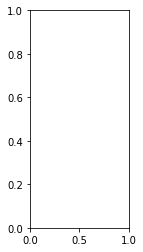

In [79]:
def count_problematic(df):
    at_least_one_null = len(df[pd.isnull(df).any(axis=1)])
    return at_least_one_null, len(df) - at_least_one_null

for i, df in enumerate([posts, locations, profiles]):
    plt.subplot(1,3,i+1)
#     plt.title(name)
    plt.pie(count_problematic(df), labels=['missing values', ''])

# [RQ2] 

#### Plot the number of posts for each profile in descending order.

In [81]:
profiles.df.sort_values(by='n_posts', ascending=False)[['profile_name', 'n_posts']]

,profile_name,n_posts
sid,,
4192500,fawaz4422,37753
4188835,djpeanutwao,14271
4185860,maciej.rekosiewicz,13831
4191788,sriutari_,12677
4191982,elf_qadin_dunyasi,11899
...,...,...
4195473,shotoniphoneseries,<NA>
4195482,ilsanders89,<NA>
4195486,grantabooks,<NA>


#### What posts have the most number of likes?

In [83]:
posts.df.sort_values(by='numbr_likes', ascending=False).head(10)

,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
sid,,,,,,,,,
28372824,3444658,BWatkdZACtC,7061024,59743640,2017-07-11 21:05:22,1,Я вот просматриваю иногда свой аккаунт Инстагр...,298913,386
26702072,301272,BP3clgjDC-Q,319897212,1029929202,2017-01-30 00:15:11,1,Iridescent pastel pink 🦄 \nCreated using Lipgl...,129571,386
28374117,548786,Bvo_FBVgypy,208502444,751708427,2019-03-30 18:12:35,1,Confirmation that Huddersfield are relegated f...,123678,484
28376593,-1,BJs2p4ZBYn3,335410451,568572977,2016-08-29 19:22:57,1,On rigole bien quand même💃🏼,106113,545
28376800,-1,BaWZhdrnL2n,530835252,274141210,2017-10-17 14:58:48,1,Algún día debería hacer una quedada 🤤🤤\nCuando...,67342,398
28375819,-1,BxDZBh-nMLT,3127385206,347539836,2019-05-04 21:50:56,1,"Prévias feitas! Agora é comer, descansar e esp...",60736,879
28375502,96176,BWV0XlLFYap,28226901,56495,2017-07-09 23:28:34,1,Baby Driver in Wellington (📸 @carmelovarela),50442,116
28378626,355000,BeoMTEvAPHr,43867292,229414338,2018-01-31 21:55:09,1,Great morning at Spence. Many thanks Hollie @h...,47271,152
28378115,-1,BvQHvOHBOab,1526791424,1018609727,2019-03-21 02:27:14,1,Măm Măm 😋😋😋 #ngoctrinh #ngoctrinhofficial #you...,47065,171


#### What posts have the most and the least number of comments?

In [84]:
posts.df.sort_values(by='number_comments', ascending=False).head(10)

,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
sid,,,,,,,,,
27386281,3398819,BgkKMt4hAW7,2955286544,1012854533,2018-03-21 01:22:38,1,"Доброе утро, красотки 💃🏻\nУ нас отличная новос...",302,13983
28374324,396283,BfrIDlygv1G,217723373,548438207,2018-02-26 21:47:12,1,"Despite a steady downpour, thousands flocked t...",23425,1340
28380873,-1,BxCwkRuAKgi,238711109,2229985840579401,2019-05-04 15:57:25,1,🎉🎉GIVEAWAY🎉🎉\n.\n@yifangtea.sg has launched th...,641,1012
28375819,-1,BxDZBh-nMLT,3127385206,347539836,2019-05-04 21:50:56,1,"Prévias feitas! Agora é comer, descansar e esp...",60736,879
25528599,-1,BtB0CP-nAIc,373344088,751708427,2019-01-24 20:02:55,1,I'm really happy for the opportunity to play i...,24232,792
28375403,87675,BxuReBznXnw,7629888318,127562401356728,2019-05-21 13:32:16,1,🍦🍨🍦Ice cream giveaway!!🍦🍨🍦\nTo kick off summer...,432,642
28376593,-1,BJs2p4ZBYn3,335410451,568572977,2016-08-29 19:22:57,1,On rigole bien quand même💃🏼,106113,545
28374117,548786,Bvo_FBVgypy,208502444,751708427,2019-03-30 18:12:35,1,Confirmation that Huddersfield are relegated f...,123678,484
28371656,-1,BfymkS7nVN8,20935109,264423834,2018-03-01 19:28:30,1,"NAME MY SHOW!!!Awhile back, I asked you guys w...",20848,467


In [85]:
posts.df.sort_values(by='number_comments', ascending=True).head(10)

,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
sid,,,,,,,,,
28370919,3496776,BXdjjUlgcgq,2237947779,1022366247837915,2017-08-06 20:06:57,2,Wreckloose! Deevalley bike park laps on the @i...,80,0
28376041,-1,BwMjxUkgPQv,8511791484,1034557833,2019-04-13 14:46:37,1,Proyecto vivienda M4\nMovo arquitectos + Arq. ...,16,0
28376037,-1,BxBEX0EAgeE,8511791484,1034557833,2019-05-04 00:12:00,1,Recorriendo la obra de vivienda M4.\nProyecto:...,16,0
28376036,-1,BxK2vweAHmW,6892350240,1034557833,2019-05-07 19:25:21,1,•EL PRÓXIMO JUEVES ESTAREMOS VISITANDO 📍COLINA...,10,0
28376035,-1,BxP9qAQgvOh,6892350240,1034557833,2019-05-09 19:01:56,1,En el día de hoy tuvimos visitas con clientes ...,7,0
28376097,-1,Bxes099FqLY,231664106,699536366861017,2019-05-15 12:23:29,1,Our own bungalow on this island🏠,101,0
28376020,-1,Bxwv_RICWDC,12836453836,331947774,2019-05-22 12:37:26,1,Questo è stato FATTO ✅ ”Si AMO Sant’Elena” in ...,9,0
28376019,-1,BxzAaPbBmBe,12836453836,331947774,2019-05-23 09:39:24,1,Questo è stato FATTO ✅ ”Si AMO Sant’Elena” in ...,24,0
28376042,-1,BwI5jUUA_LQ,8511791484,1034557833,2019-04-12 04:39:59,1,Se sigue avanzando. Vivienda M4 Colinas de Car...,18,0


#### How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.

([<matplotlib.patches.Wedge at 0x7f128f159fd0>,
 [Text(1.1, 0.0, 'null'), Text(-1.1, 1.3471114790620887e-16, 'tagged')])

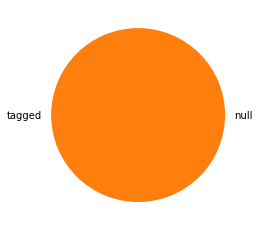

In [87]:
null_locations = sum(posts['location_id'].isna())
plt.pie([null_locations, len(posts.df)-null_locations], labels=['null', 'tagged'])

#### How many posts include only photos? How many also have videos?

In [88]:
def categorize(mapping, values):
    res = pd.DataFrame.from_dict(mapping, orient='index', columns=['count'])
    for k,v in mapping.items():
        res.loc[k] = sum(values == v)
    res.loc['NA'] = sum(values.isna())
    if res.loc['NA'].sum() == 0:
        return res.loc[mapping.keys()]
    else:
        return res

[Text(0.5, 1.0, 'Post types')]

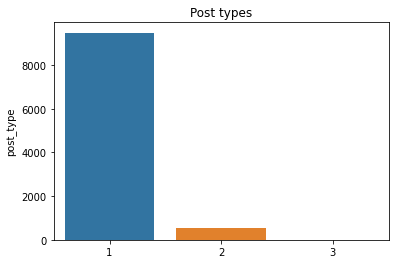

In [89]:
post_types = posts['post_type'].value_counts(dropna=False)
sns.barplot(y=post_types, x=post_types.index).set(title='Post types')

#### What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?

[Text(0.5, 1.0, 'Business Accounts')]

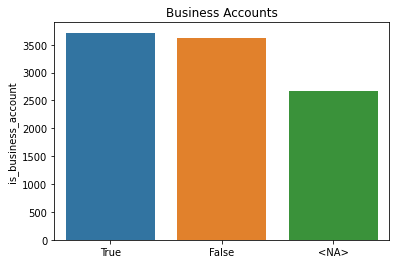

In [95]:
business_accounts = profiles.df['is_business_account'].value_counts(dropna=False)
sns.barplot(x=[True, False, '<NA>'], y=business_accounts).set(title='Business Accounts')